# OPEN THE DATA 

In [ ]:
# 기본세팅
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [ ]:
# 데이터 불러오기
df=pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv')
#불필요 컬럼 삭제
df=df.drop(df.columns[[0]], axis='columns') 
# 데이터 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


## Null Value Calculation

In [ ]:
# 결측치 확인
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

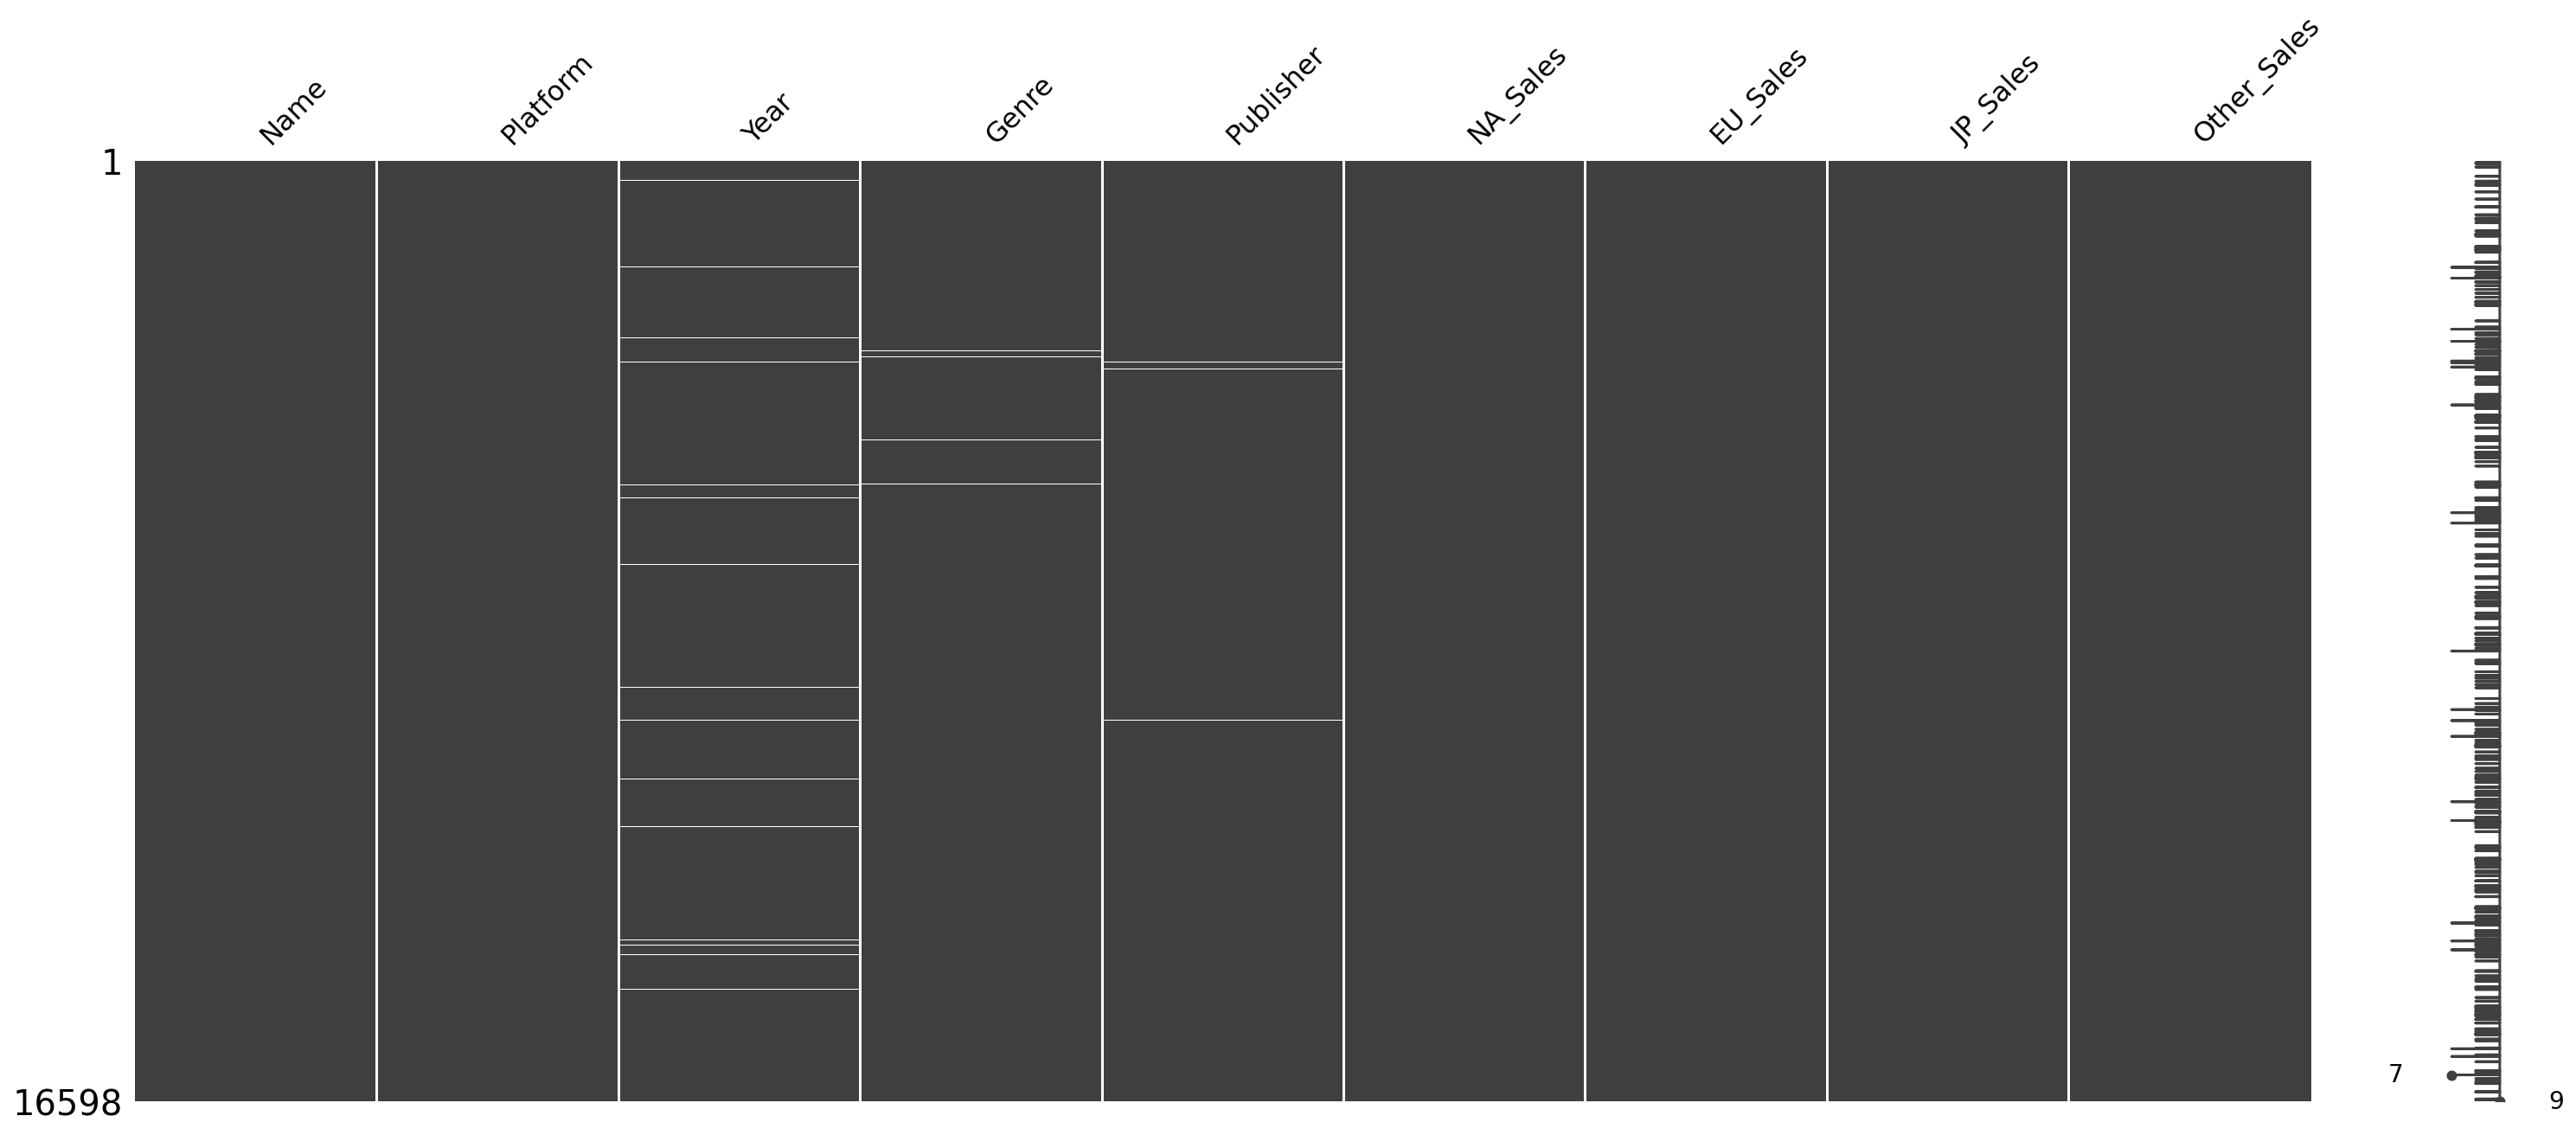

In [ ]:
# 그래프로 확인
import missingno as msno
msno.matrix(df)

# Data Preprocessing 



---
## Year cloumn


In [ ]:
# Year 칼럼 확인
df['Year'].value_counts()

2009.0    1421
2008.0    1418
2010.0    1252
2007.0    1199
2011.0    1129
          ... 
14.0         2
13.0         2
94.0         1
2020.0       1
86.0         1
Name: Year, Length: 62, dtype: int64

In [ ]:
# 2020년도 항목이 1인 것이 이상하여 데이터 확인
year_data = df['Year']
max_y_df = year_data.idxmax()
max_y_df = df.iloc[max_y_df]
pd.DataFrame(max_y_df).T

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
6906,Imagine: Makeup Artist,DS,2020,Simulation,Ubisoft,0.27,0K,0,0.02


In [ ]:
# 게임명 확인 결과 Imagine:Makeup Artist게임은 2009년 출시 됨
df['Year'] = df['Year'].replace(2020.0, 2009.0)
print(df['Year'].max())

2017.0


In [ ]:
# Year 컬럼 변환 함수 선언
def yc(j):          
    if 20>=j>=0:         # 0~20은 2000년대일 것이라 예측
        return 2000+j 
    elif 99>j>21:        # 21~99는 1900년대일 것이라 예측
        return 1900+j
    else:
        return j

df['Year']=df['Year'].apply(yc)

In [ ]:
# Year 칼럼 재확인
print(df['Year'].min())

1980.0


In [ ]:
# Name에 Year에 대한 정보가 들어있는 컬럼들이 있음
cond11=df['Name']=='FIFA Soccer 2004'
df.loc[cond11]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1099,FIFA Soccer 2004,GC,2003.0,Sports,Electronic Arts,0.05,0.01,0,0
9954,FIFA Soccer 2004,XB,2003.0,Sports,Electronic Arts,0.24,0.49,0,0.05
10965,FIFA Soccer 2004,PS2,NaN,Sports,Electronic Arts,0.59,2.36,0.04,0.51
13387,FIFA Soccer 2004,GBA,2003.0,Sports,Electronic Arts,0.04,0.01,0,0


In [ ]:
# Name에서 Year정보를 취하는 함수 선언
def get_num(i):
    return (''.join(ele for ele in i if ele.isdigit()))
df['Year1']=df['Name'].apply(get_num)

In [ ]:
# 칼럼 정리
df['Year1'] = pd.to_numeric(df['Year1'])
df['Year1'].fillna(0,inplace=True)
df['Year1'].values

array([  0.,   0.,   0., ..., 216.,   0.,  95.])

In [ ]:
# 확실한 Year정보들이 있는 2000년대 정보만 반환하여 저장 하도록 함수 선언
def addy(x):        
    if 2020>x>2000:
        return x-1 # Year값은 보통 Name-1
    else:
        return None     

df['Year1']=df['Year1'].apply(addy)
df['Year'].fillna(df['Year1'], inplace=True)
df=df.drop(df.columns[[-1]], axis='columns')   

In [ ]:
# Name에 Year에 대한 정보 재 확인
cond12=df['Name']=='FIFA Soccer 2004'
df.loc[cond12]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1099,FIFA Soccer 2004,GC,2003.0,Sports,Electronic Arts,0.05,0.01,0,0
9954,FIFA Soccer 2004,XB,2003.0,Sports,Electronic Arts,0.24,0.49,0,0.05
10965,FIFA Soccer 2004,PS2,2003.0,Sports,Electronic Arts,0.59,2.36,0.04,0.51
13387,FIFA Soccer 2004,GBA,2003.0,Sports,Electronic Arts,0.04,0.01,0,0


In [ ]:
# Year 칼럼의 value_counts 확인 및 결측치를 median 값으로 채움 
df['Year'].value_counts()
df['Year'].fillna(2007, inplace=True)
df['Year'].isnull().sum()

0



---
## Sales columns


In [ ]:
# 4개의 Sales 칼럼 정리를 위한 value 확인 1
df['NA_Sales'].value_counts()

0       4443
0.02     537
0.01     536
0.03     528
0.05     523
        ... 
3.49       1
4.12       1
490K       1
4.74       1
2.17       1
Name: NA_Sales, Length: 494, dtype: int64

In [ ]:
# 각 Sales 칼럼에 대한 데이터 전처리
# Sales의 단위가 'M'이므로, M문자열 삭제 함수 선언
def replace(x):
    return (x.replace('M',''))

# 함수 적용
df['NA_Sales']=df['NA_Sales'].apply(replace)
df['EU_Sales']=df['EU_Sales'].apply(replace)
df['JP_Sales']=df['JP_Sales'].apply(replace)
df['Other_Sales']=df['Other_Sales'].apply(replace)

In [ ]:
# 4개의 Sales 칼럼 정리를 위한 value 확인 2
df['NA_Sales'].value_counts()

0       4473
0.02     544
0.01     539
0.03     530
0.05     526
        ... 
6.05       1
2.4        1
270K       1
5.58       1
2.17       1
Name: NA_Sales, Length: 451, dtype: int64

In [ ]:
# Sales의 단위가 M이므로, K문자열 삭제 및 M단위로 변환 함수 선언
def rnc(k):        
    if 'K' in k:
        return float(k.replace('K',''))*0.001
    else:
        return k

# 함수 적용
df['NA_Sales']=df['NA_Sales'].apply(rnc)
df['EU_Sales']=df['EU_Sales'].apply(rnc)
df['JP_Sales']=df['JP_Sales'].apply(rnc)
df['Other_Sales']=df['Other_Sales'].apply(rnc)

In [ ]:
# 4개의 Sales 칼럼 정리를 위한 value 확인 3
df['NA_Sales'].value_counts()

0       4473
0.02     544
0.01     539
0.03     530
0.05     526
        ... 
0.19       1
3.5        1
2.17       1
0.6        1
1.83       1
Name: NA_Sales, Length: 451, dtype: int64

In [ ]:
# numerical data type 변환
df=df.astype({'Year':int, 'NA_Sales': np.float, 'EU_Sales': np.float, 'JP_Sales': np.float,'Other_Sales': np.float})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16598 non-null  int64  
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.1+ MB


---
## Genre column

In [ ]:
# 보통 이름이 같은 게임과 동일한 값을 가지고 있으나 Platform이 다름
cond15=df['Name']=='Cloudy With a Chance of Meatballs'
df.loc[cond15]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
3505,Cloudy With a Chance of Meatballs,X360,2009,Platform,Ubisoft,0.07,0.01,0.0,0.01
4990,Cloudy With a Chance of Meatballs,PSP,2009,Platform,Ubisoft,0.07,0.00,0.0,0.01
5050,Cloudy With a Chance of Meatballs,DS,2009,Platform,Ubisoft,0.20,0.01,0.0,0.02
11268,Cloudy With a Chance of Meatballs,PS3,2009,NaN,Ubisoft,0.09,0.01,0.0,0.01
13065,Cloudy With a Chance of Meatballs,Wii,2009,Platform,Ubisoft,0.11,0.00,0.0,0.01


In [ ]:
# Name으로 data정렬후, 결측치를 바로 윗 행의 값으로 채워주고 확인
df.sort_values(by='Name', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df['Genre'].fillna(method='ffill', inplace=True)
cond16=df['Name']=='Cloudy With a Chance of Meatballs'
df.loc[cond16]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
2207,Cloudy With a Chance of Meatballs,Wii,2009,Platform,Ubisoft,0.11,0.00,0.0,0.01
2208,Cloudy With a Chance of Meatballs,X360,2009,Platform,Ubisoft,0.07,0.01,0.0,0.01
2209,Cloudy With a Chance of Meatballs,PSP,2009,Platform,Ubisoft,0.07,0.00,0.0,0.01
2210,Cloudy With a Chance of Meatballs,DS,2009,Platform,Ubisoft,0.20,0.01,0.0,0.02
2211,Cloudy With a Chance of Meatballs,PS3,2009,Platform,Ubisoft,0.09,0.01,0.0,0.01


In [ ]:
# 결측치 재 확인
df.isnull().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher      58
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
dtype: int64

## Publisher column

In [ ]:
# Publisher 결측치에 대해 다른 컬럼들로 부터 어떠한 정보를 찾기 어려움으로 해당 결측치 row 삭제 
df.dropna(inplace=True)
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

# Feature Engineering

## Sum Sales Feature

In [ ]:
# 각 Sales columns의 합으로 구성된 Sum_Sales Feature 생성
df['Sum_Sales']=df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales']
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sum_Sales
0,'98 Koshien,PS,1998,Sports,Magical Company,0.15,0.10,0.12,0.03,0.40
1,.hack//G.U. Vol.1//Rebirth,PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17
2,.hack//G.U. Vol.2//Reminisce,PS2,2006,Role-Playing,Namco Bandai Games,0.11,0.09,0.00,0.03,0.23
3,.hack//G.U. Vol.2//Reminisce (jp sales),PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.16,0.00,0.16
4,.hack//G.U. Vol.3//Redemption,PS2,2007,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17


## Year Group Feature

In [ ]:
# Year를 10년 단위로 categorical feature로 만들어줌

df['YearGroup'] = 0
df.loc[(df['Year'] >= 1980) & (df['Year'] <= 1989), 'YearGroup'] = '1980s'
df.loc[(df['Year'] > 1989) & (df['Year'] <= 1999), 'YearGroup'] = '1990s'
df.loc[(df['Year'] > 1999) & (df['Year'] <= 2009), 'YearGroup'] = '2000s'
df.loc[(df['Year'] > 2009) & (df['Year'] <= 2019), 'YearGroup'] = '2010s'

df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sum_Sales,YearGroup
0,'98 Koshien,PS,1998,Sports,Magical Company,0.15,0.10,0.12,0.03,0.40,1990s
1,.hack//G.U. Vol.1//Rebirth,PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17,2000s
2,.hack//G.U. Vol.2//Reminisce,PS2,2006,Role-Playing,Namco Bandai Games,0.11,0.09,0.00,0.03,0.23,2000s
3,.hack//G.U. Vol.2//Reminisce (jp sales),PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.16,0.00,0.16,2000s
4,.hack//G.U. Vol.3//Redemption,PS2,2007,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17,2000s


In [ ]:
df['YearGroup'].value_counts()

2000s    9431
2010s    5135
1990s    1769
1980s     205
Name: YearGroup, dtype: int64

# Exploratory Data Analysis

## Correlation of Regional Sales

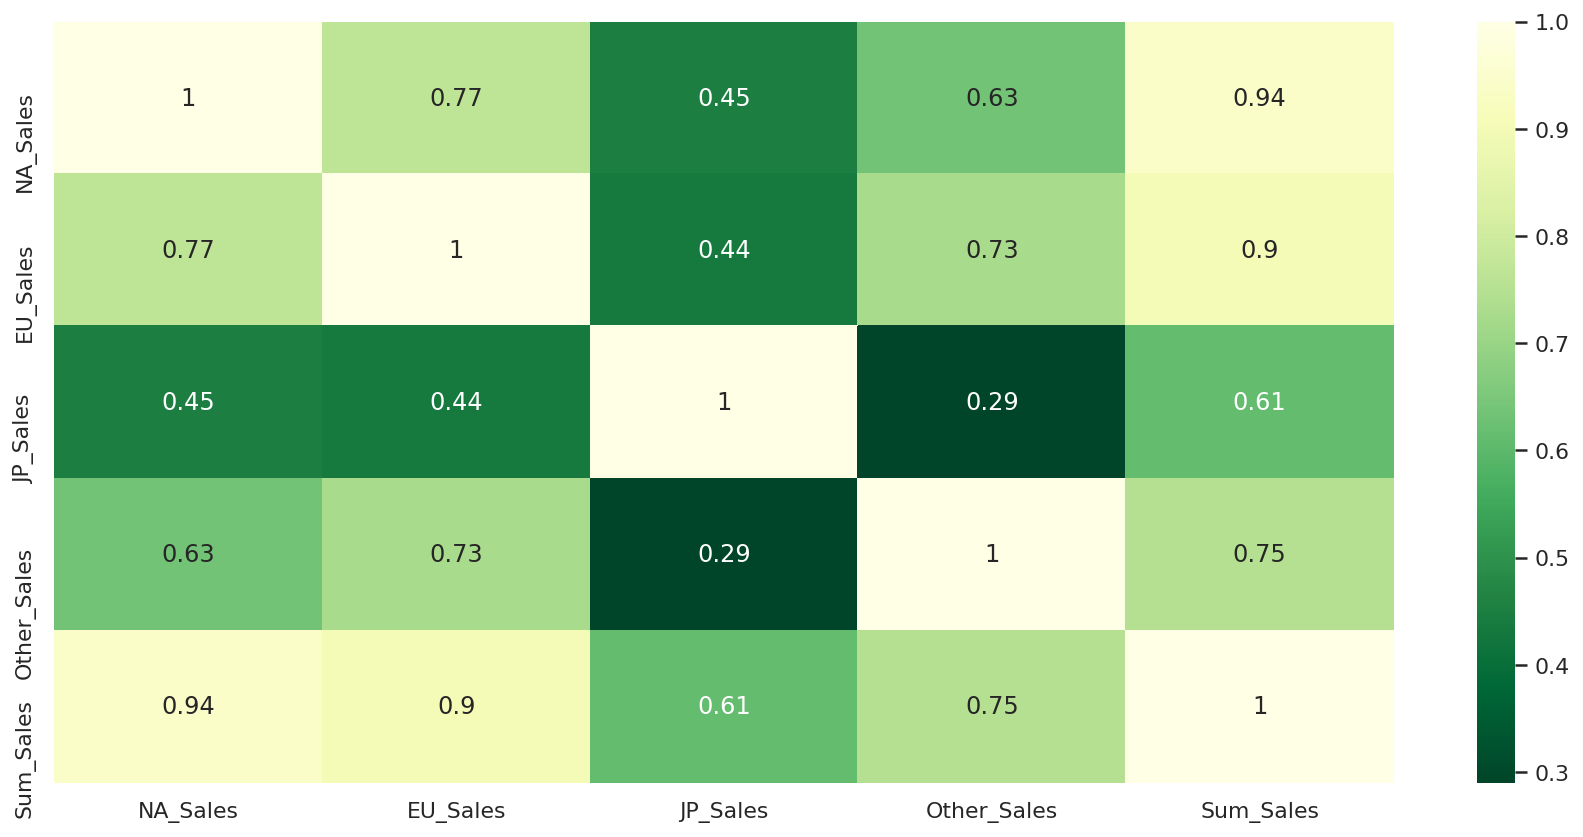

In [ ]:
# 전체 및 각 지역별 매출의 상관관계 확인
GS_df=df.iloc[:, 5:10]
GS_df_corr = GS_df.corr()
plt.figure(figsize=(15,7))
#plot heat map
g=sns.heatmap(GS_df_corr,annot=True,cmap='YlGn_r')

> **시각화 결과를 통해 일본지역과 다른 지역의 상관관계가 가장 적음을 알수 있음<br> NA와 EU의 매출이 전체 매출에 영향을 주고 있음을 알 수 있음**


## Market Share by Region

In [ ]:
# 지역별 매출 총액 확인
ts_df = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
ts_df = ts_df.sum().reset_index()
ts_df = ts_df.rename(columns={"index": "region", 0: "sale"})
ts_df

,region,sale
0,NA_Sales,4384.41
1,EU_Sales,2429.45
2,JP_Sales,1290.09
3,Other_Sales,797.08


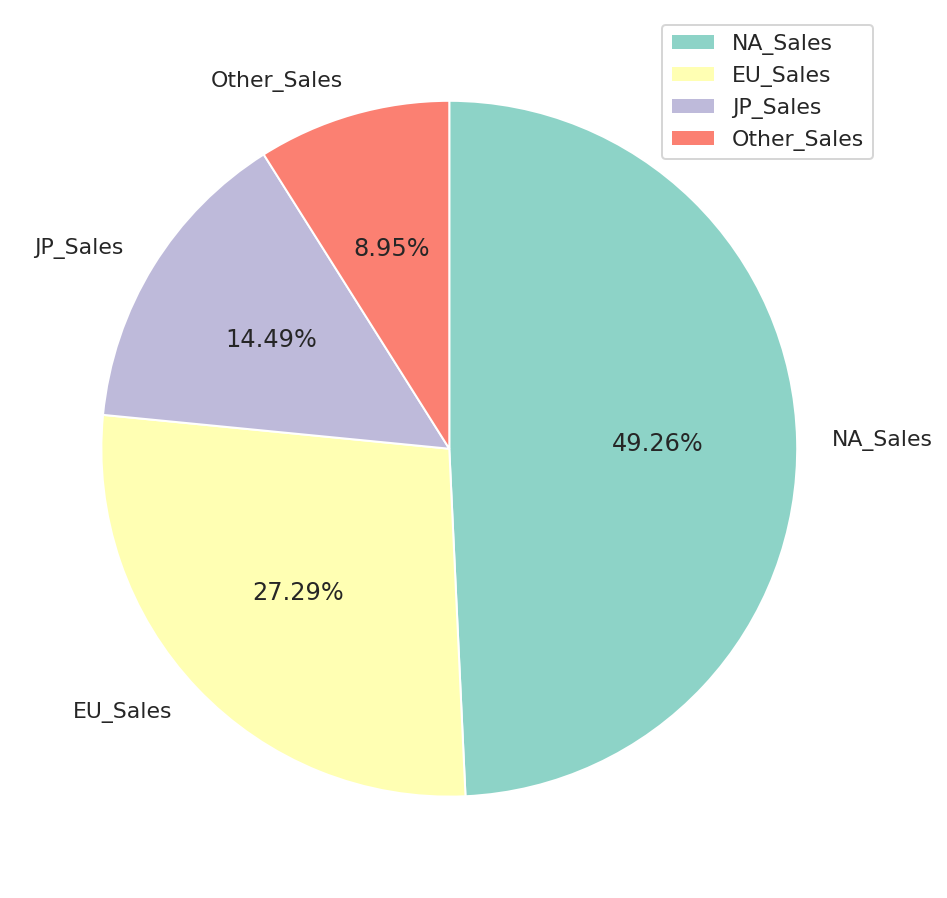

In [ ]:
# 그래프로 확인
fig = plt.figure(figsize=(8,8)) 
sns.set_palette('Set3',4)
ax = fig.add_subplot()
ax.pie(ts_df['sale'], 
       labels=ts_df['region'],
       startangle=90, 
       counterclock=False, 
       autopct=lambda p : '{:.2f}%'.format(p))
plt.legend()
plt.show()

## Game Release & Sales Volume by Decade

In [ ]:
# 연도별 게임 출시량
vc_y_df=df['YearGroup'].value_counts()
vc_y_df=pd.DataFrame(vc_y_df)
vc_y_df.reset_index(inplace=True)
vc_y_df=vc_y_df.sort_values(by='index', ascending=True)
vc_y_df.rename(columns = {'index': 'YearGroup','YearGroup':'Count'}, inplace = True)
vc_y_df

# 연도별 게임 판매량
ys_df = df.groupby(by=['YearGroup'])['Sum_Sales'].sum().reset_index()
ys_df

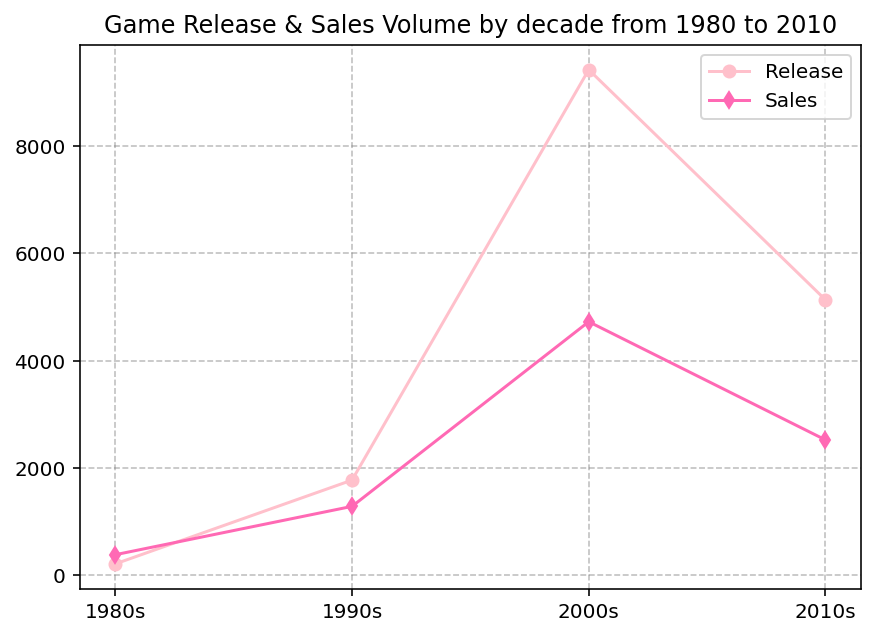

In [ ]:
# 그래프로 확인
years=vc_y_df['YearGroup']
count=vc_y_df['Count']
sales=ys_df['Sum_Sales']

plt.figure(figsize = (7, 5)) 
ax = plt.subplot() 
ax.plot(years,count,marker='o',label='Release', color='pink')
ax.plot(years,sales,marker='d',label='Sales', color='hotpink') 
ax.legend()
plt.grid(True, color='gray', alpha=0.5, linestyle='--') 
plt.title('Game Release & Sales Volume by decade from 1980 to 2010')
plt.show()

## Regional Sales by Genre

In [ ]:
# 장르별 매출액 확인
GS_df=df.groupby('Genre').sum()
GS_df=GS_df.drop(GS_df.columns[[0]], axis=1)
GS_df1=GS_df.drop(GS_df.columns[[-1]],axis=1)
GS_df1


,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,876.22,523.95,158.58,186.87
Adventure,106.77,64.74,53.23,17.07
Fighting,221.92,100.24,87.35,36.24
Misc,405.28,213.93,107.84,75.28
Platform,446.99,201.15,130.65,51.55
Puzzle,128.72,54.82,61.65,13.33
Racing,359.41,238.38,56.74,77.27
Role-Playing,321.46,183.58,347.28,58.70
Shooter,583.56,314.00,38.54,103.04


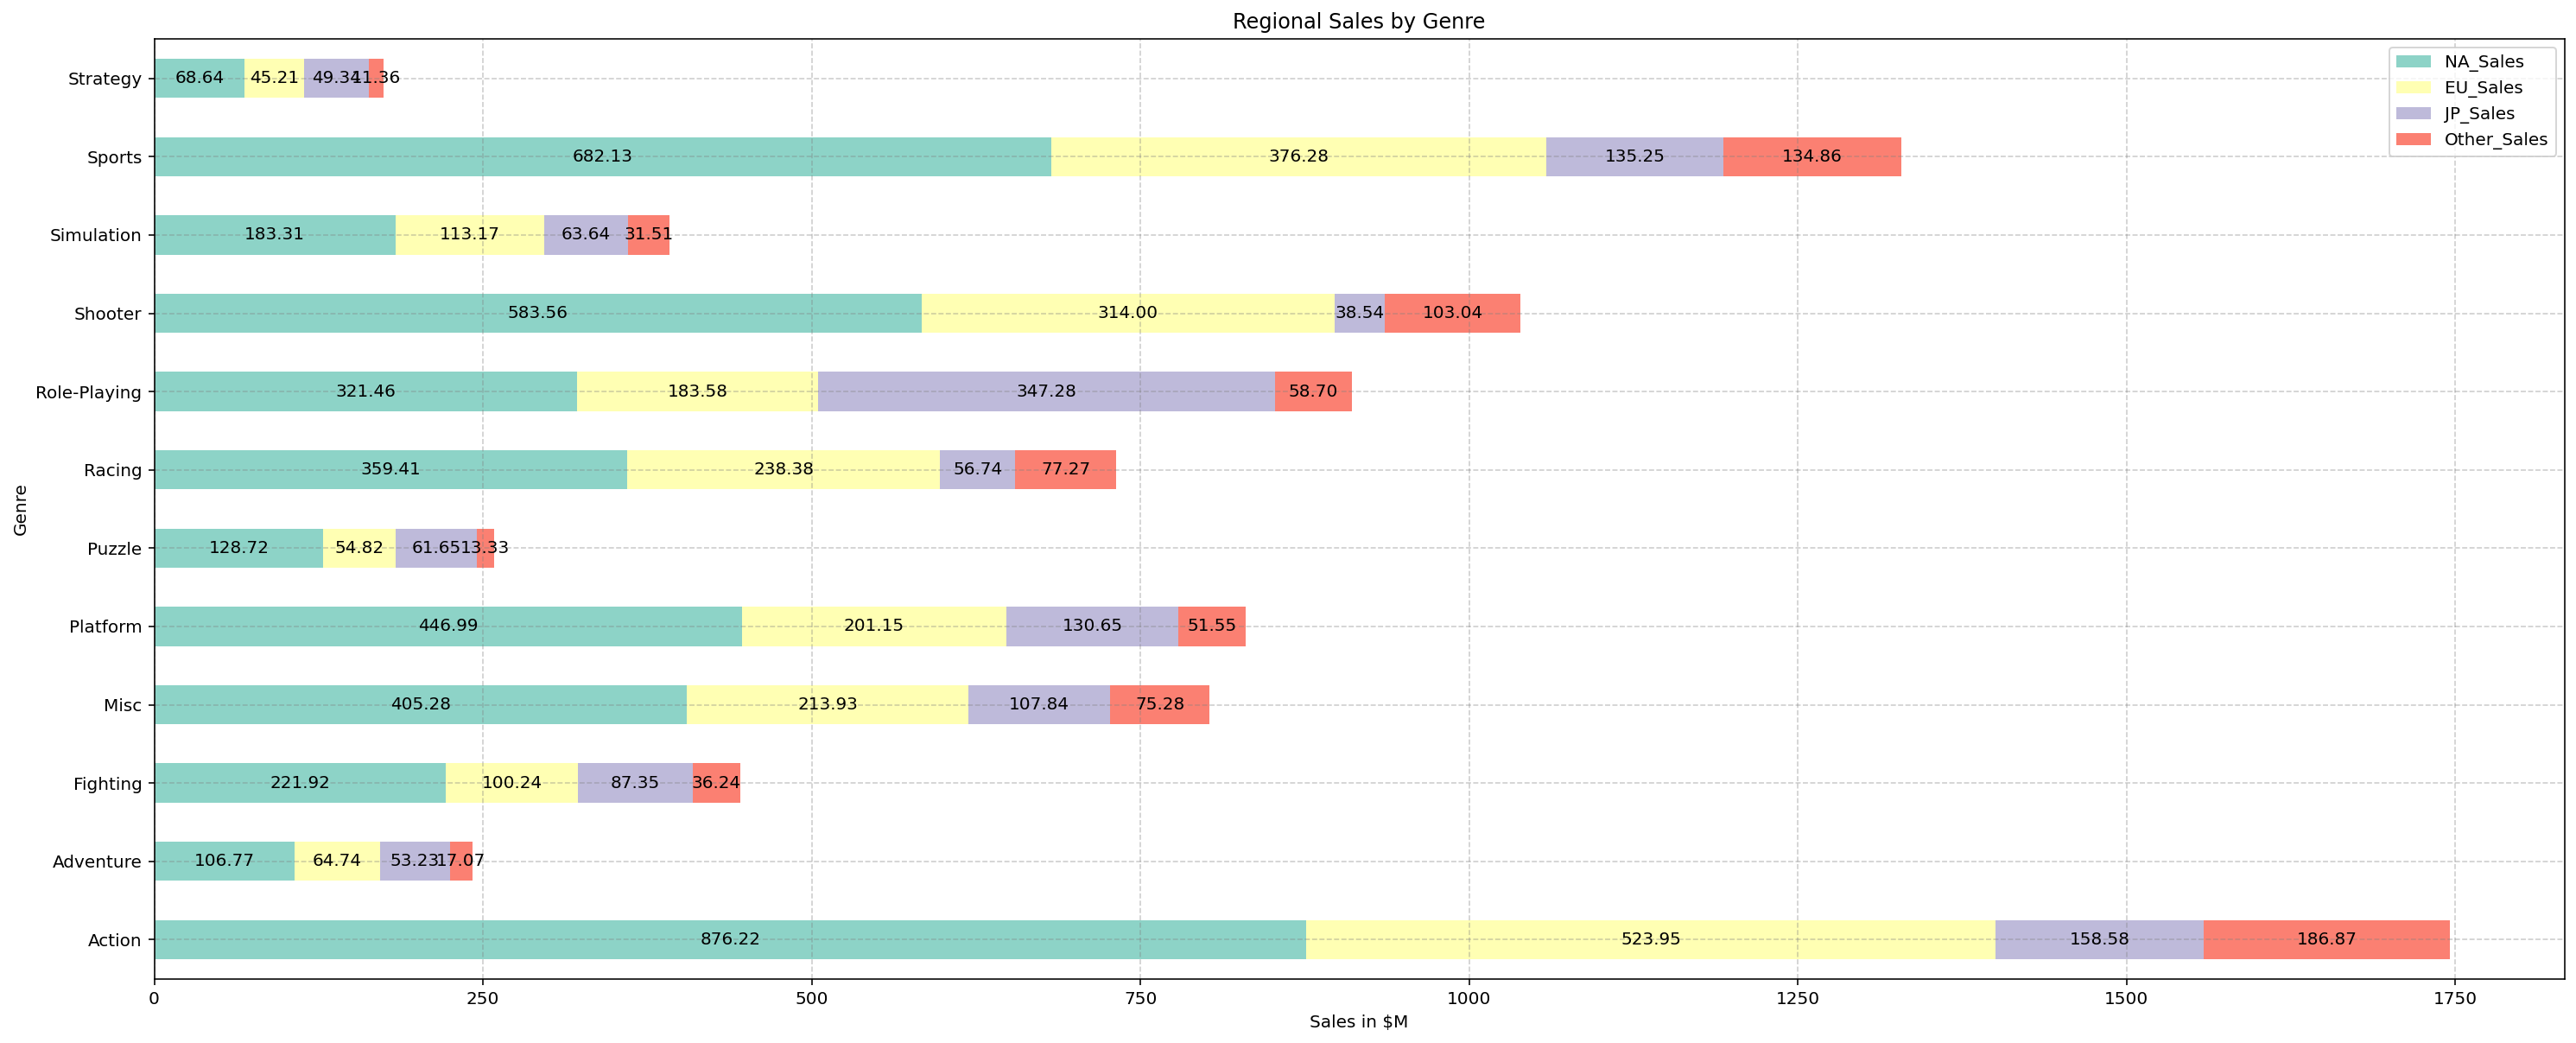

In [ ]:
# 누적 그래프로 확인
colors = sns.color_palette('Set3', n_colors=len(GS_df1.columns))
ax = GS_df1.plot.barh(stacked=True, figsize=(25, 10), color=colors)
ax.legend()
handles, labels = ax.get_legend_handles_labels()  
# 그래프 주석 달기
counter = 0  
for i, p in enumerate(ax.patches, 0): 
    if (i % len(GS_df) == 0) & (i != 0):  
        counter += 1  
    left, bottom, width, height = p.get_bbox().bounds
    label = labels[counter]  
    if width > 0:
         ax.annotate((f'{width:.2f}'), xy=(left+width/2, bottom+height/2), ha='center', va='center')

ax.set_xlabel('Sales in $M')
ax.set_ylabel('Genre')
plt.title('Regional Sales by Genre')
plt.grid(True, color='gray', alpha=0.4, linestyle='--')
plt.show();

> **시각화 결과를 통해 지역별 선호 장르 확인**<br>
**NA(north america) - action / EU(europe) - action / JP(japan) - role-playing / others - action**<br>

## Change to Genre by Year

In [ ]:
# Genre & Year two sample chi square test 실행 

from scipy.stats import chi2_contingency # scipy에서 two sample chi square test 모듈 사용
result1_chi2=chi2_contingency(pd.crosstab(df['Genre'], df['YearGroup']))

print('Genre와 Year의 P-value 값: ', result1_chi2[1])

Genre와 Year의 P-value 값:  2.373823213011235e-197


>  연도에 대해 장르에 차이가 있는지에 대해 2 sample chi square test 확인 결과,<br> P-value의 값이 0.05보다 작으므로 유의미한 차이가 있음을 확인함<br> 따라서 귀무가설을 기각하며, 연도와 장르는 독립적이지 않음을 확인 함<br>
귀무가설 설정: Year와 Genre는 서로 독립적일 것이다(영향을 받지 않음) <br>
대안가설 설정: Year와 Genre는 서로 독립적이지 않을 것이다(영향을 받음)

In [ ]:
df_p=df.pivot_table(values='Sum_Sales', index='Genre', columns='YearGroup', aggfunc='sum')
df_p.fillna(0, inplace=True) # Year를 Group화 할 경우 장르와 일치하지 않는 값이 생길 경우 결측치로 처리 됨에 따라 결측치를 0으로 채워줌
df_p

YearGroup,1980s,1990s,2000s,2010s
Genre,,,,
Action,51.10,139.15,884.27,671.10
Adventure,4.78,46.76,129.31,60.96
Fighting,7.24,123.51,232.93,82.07
Misc,8.44,63.43,492.37,238.09
Platform,122.76,208.87,377.98,120.73
Puzzle,62.75,38.94,121.30,35.53
Racing,12.10,150.33,445.62,123.75
Role-Playing,15.25,182.77,421.66,291.34
Shooter,59.77,68.89,445.46,465.02


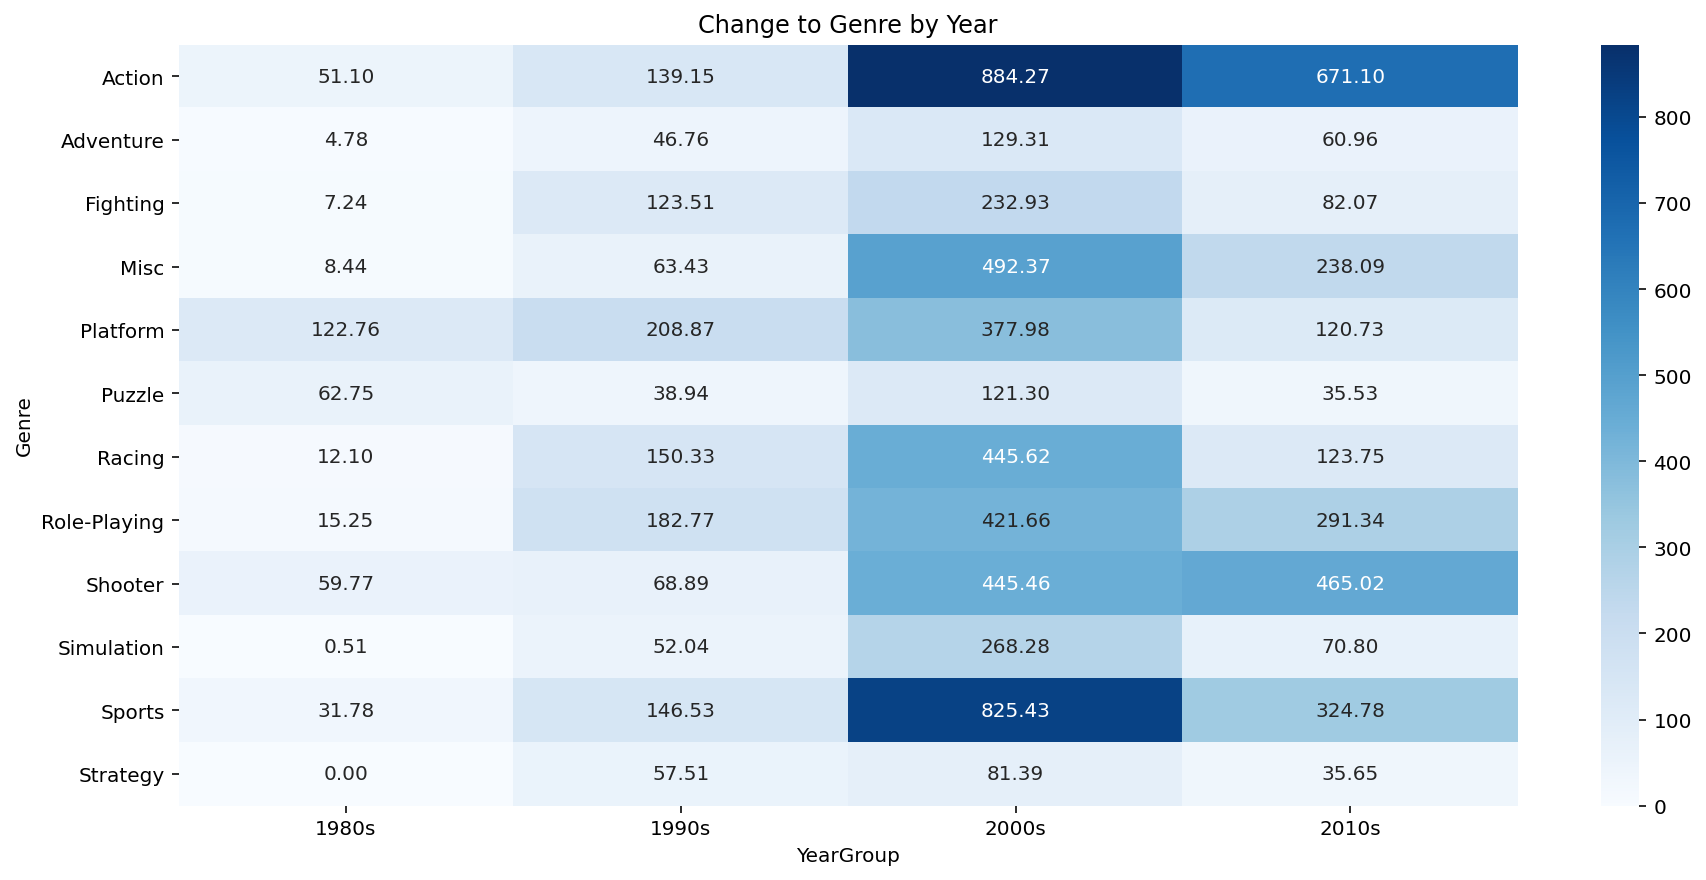

In [ ]:
# heatmap으로 확인
plt.figure(figsize=(15,7))
sns.heatmap(df_p,  annot=True, fmt='.2f', cmap='Blues')
plt.title('Change to Genre by Year')
plt.show();

>**시각화 결과를 통해 연도별로 선호하는 장르에 차이가 있음을 알 수 있음**<br>
**1980s~1990s: Platform, 2000s: Action, Sports, 2010s: Action, Shooter**

In [ ]:
# 연도별 가장 많이 출시 된 장르
y_m_df = df.groupby(['YearGroup', 'Genre']).size().reset_index(name='counts')
ym_p=y_m_df.pivot_table(values='counts', index='Genre', columns='YearGroup', aggfunc='sum')
ym_p.fillna(0, inplace=True)
ym_p

YearGroup,1980s,1990s,2000s,2010s
Genre,,,,
Action,66.0,161.0,1644.0,1438.0
Adventure,2.0,99.0,642.0,541.0
Fighting,4.0,193.0,453.0,197.0
Misc,8.0,115.0,1027.0,563.0
Platform,34.0,125.0,575.0,150.0
Puzzle,19.0,71.0,373.0,116.0
Racing,8.0,183.0,822.0,235.0
Role-Playing,9.0,171.0,747.0,557.0
Shooter,30.0,137.0,747.0,396.0


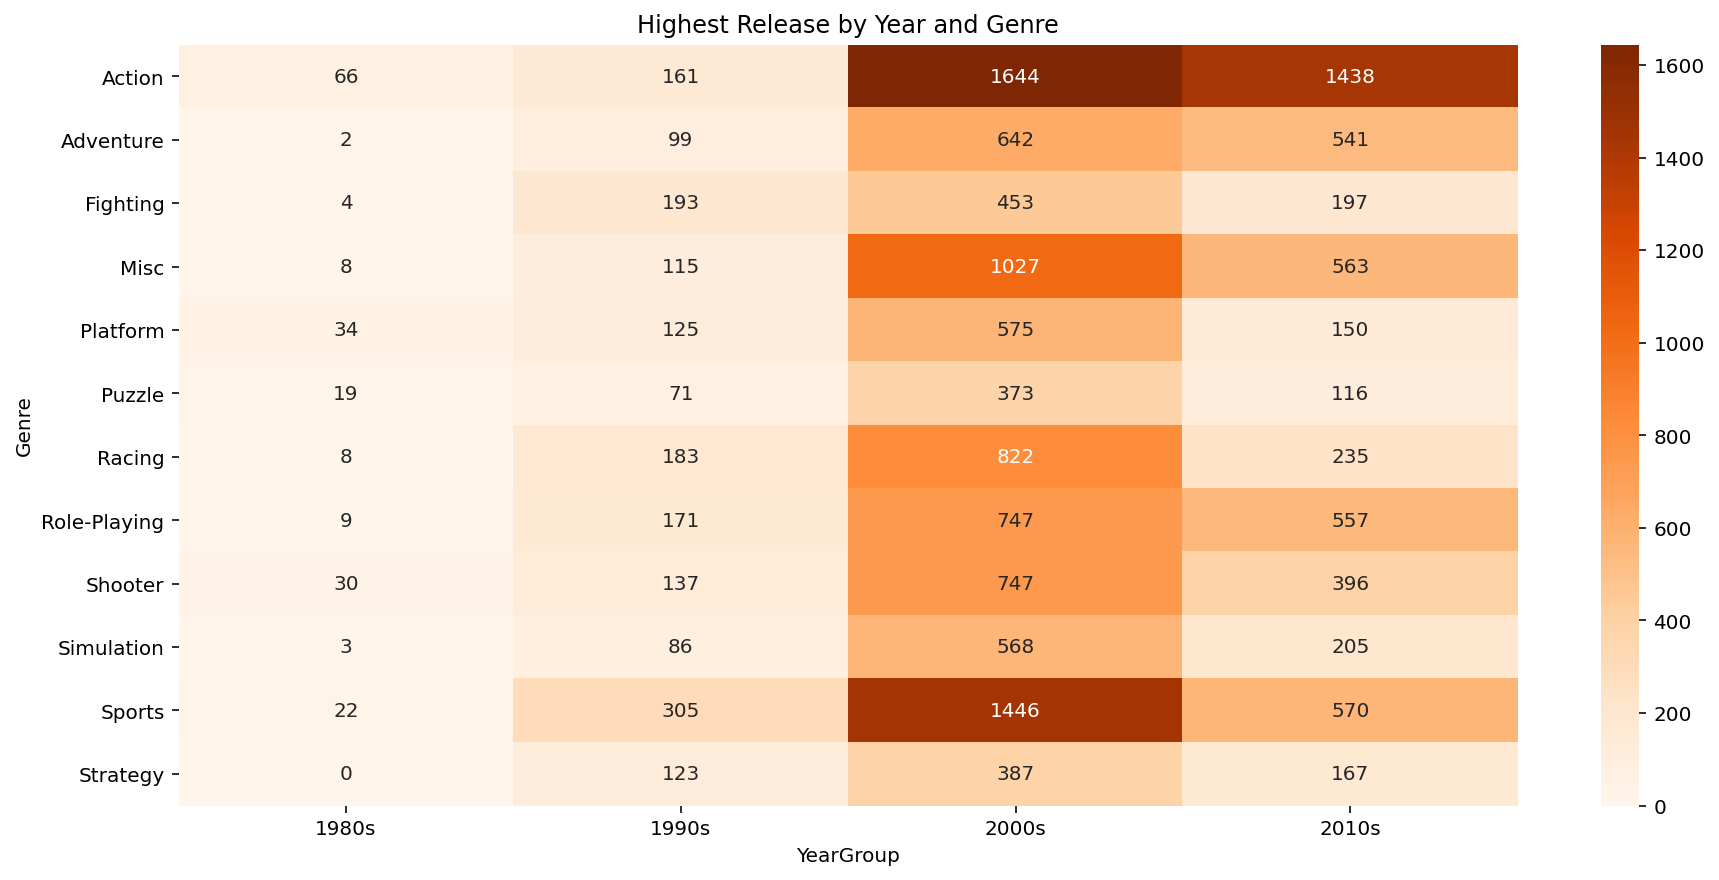

In [ ]:
# heatmap으로 확인
plt.figure(figsize=(15,7))
sns.heatmap(ym_p,  annot=True, fmt='.0f', cmap='Oranges')
plt.title('Change to Genre by Decade (Release)')
plt.show();

In [ ]:
# 연도별 가장 많이 출시 된 장르
y_m_df = df.groupby(['YearGroup', 'Genre']).size().reset_index(name='counts')
y_m_i = y_m_df.groupby(['YearGroup'])['counts'].transform(max) == y_m_df['counts']
y_m_g = y_m_df[y_m_i].reset_index(drop=True)
y_m_g = y_m_g.drop_duplicates(subset=['YearGroup', 'counts'], keep='last').reset_index(drop=True)
y_m_g

,YearGroup,Genre,counts
0,1980s,Action,66
1,1990s,Sports,305
2,2000s,Action,1644
3,2010s,Action,1438


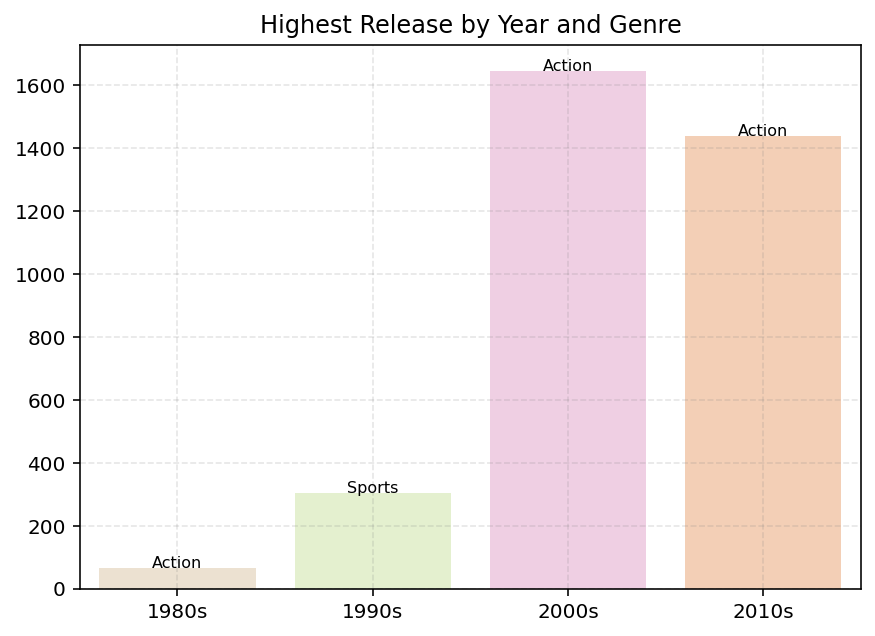

In [ ]:
# 그래프로 확인
genre=y_m_g['Genre']
plt.figure(figsize=(7,5))
sns.set_palette('Pastel2_r',4)
g = sns.barplot(x='YearGroup', y='counts', data=y_m_g)
index = 0
for value in y_m_g['counts']:
    g.text(index, value + 1, str(genre[index]), color='k', size=8, ha='center')
    index += 1
plt.grid(True, color='gray', alpha=0.2, linestyle='--')
plt.title('Highest Release by Year and Genre')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
# 연도별 가장 판매량 높은 장르
y_s_df = df.groupby(by=['YearGroup', 'Genre'])['Sum_Sales'].sum().reset_index()
y_s = y_s_df.groupby(by=['Year'])['Sum_Sales'].transform(max) == y_s_df['Sum_Sales']
y_s_m = y_s_df[y_s].reset_index(drop=True)
y_s_m

,YearGroup,Genre,Sum_Sales
0,1980s,Platform,122.76
1,1990s,Platform,208.87
2,2000s,Action,884.27
3,2010s,Action,671.10


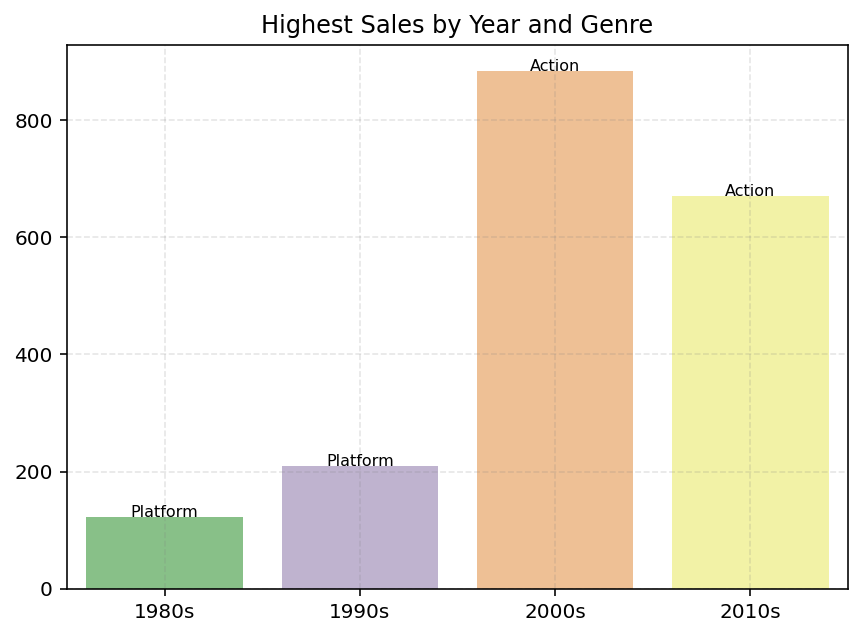

In [ ]:
# 그래프로 확인
genre=y_s_m['Genre']
sns.set_palette('Accent',4)
plt.figure(figsize=(7,5))
g = sns.barplot(x='YearGroup', y='Sum_Sales', data=y_s_m)
index = 0
for value in y_s_m['Sum_Sales']:
    g.text(index, value + 1, str(genre[index]), color='k', size=8, ha='center')
    index += 1
plt.title('Highest Sales by Year and Genre')
plt.grid(True, color='gray', alpha=0.2, linestyle='--')
plt.xlabel('')
plt.ylabel('')
plt.show()



## Top5 Game by Region

---



In [ ]:
# 지역별 Top 5 game 
NA = df.pivot_table('NA_Sales', columns='Name', aggfunc='sum').T
NA = NA.sort_values(by='NA_Sales', ascending=False).iloc[0:5]
NA.reset_index(inplace=True)

EU = df.pivot_table('EU_Sales', columns='Name', aggfunc='sum').T
EU = EU.sort_values(by='EU_Sales', ascending=False).iloc[0:5]
EU.reset_index(inplace=True)

JP = df.pivot_table('JP_Sales', columns='Name', aggfunc='sum').T
JP = JP.sort_values(by='JP_Sales', ascending=False).iloc[0:5]
JP.reset_index(inplace=True)

Other = df.pivot_table('Other_Sales', columns='Name', aggfunc='sum').T
Other = Other.sort_values(by='Other_Sales', ascending=False).iloc[0:5]
Other.reset_index(inplace=True)

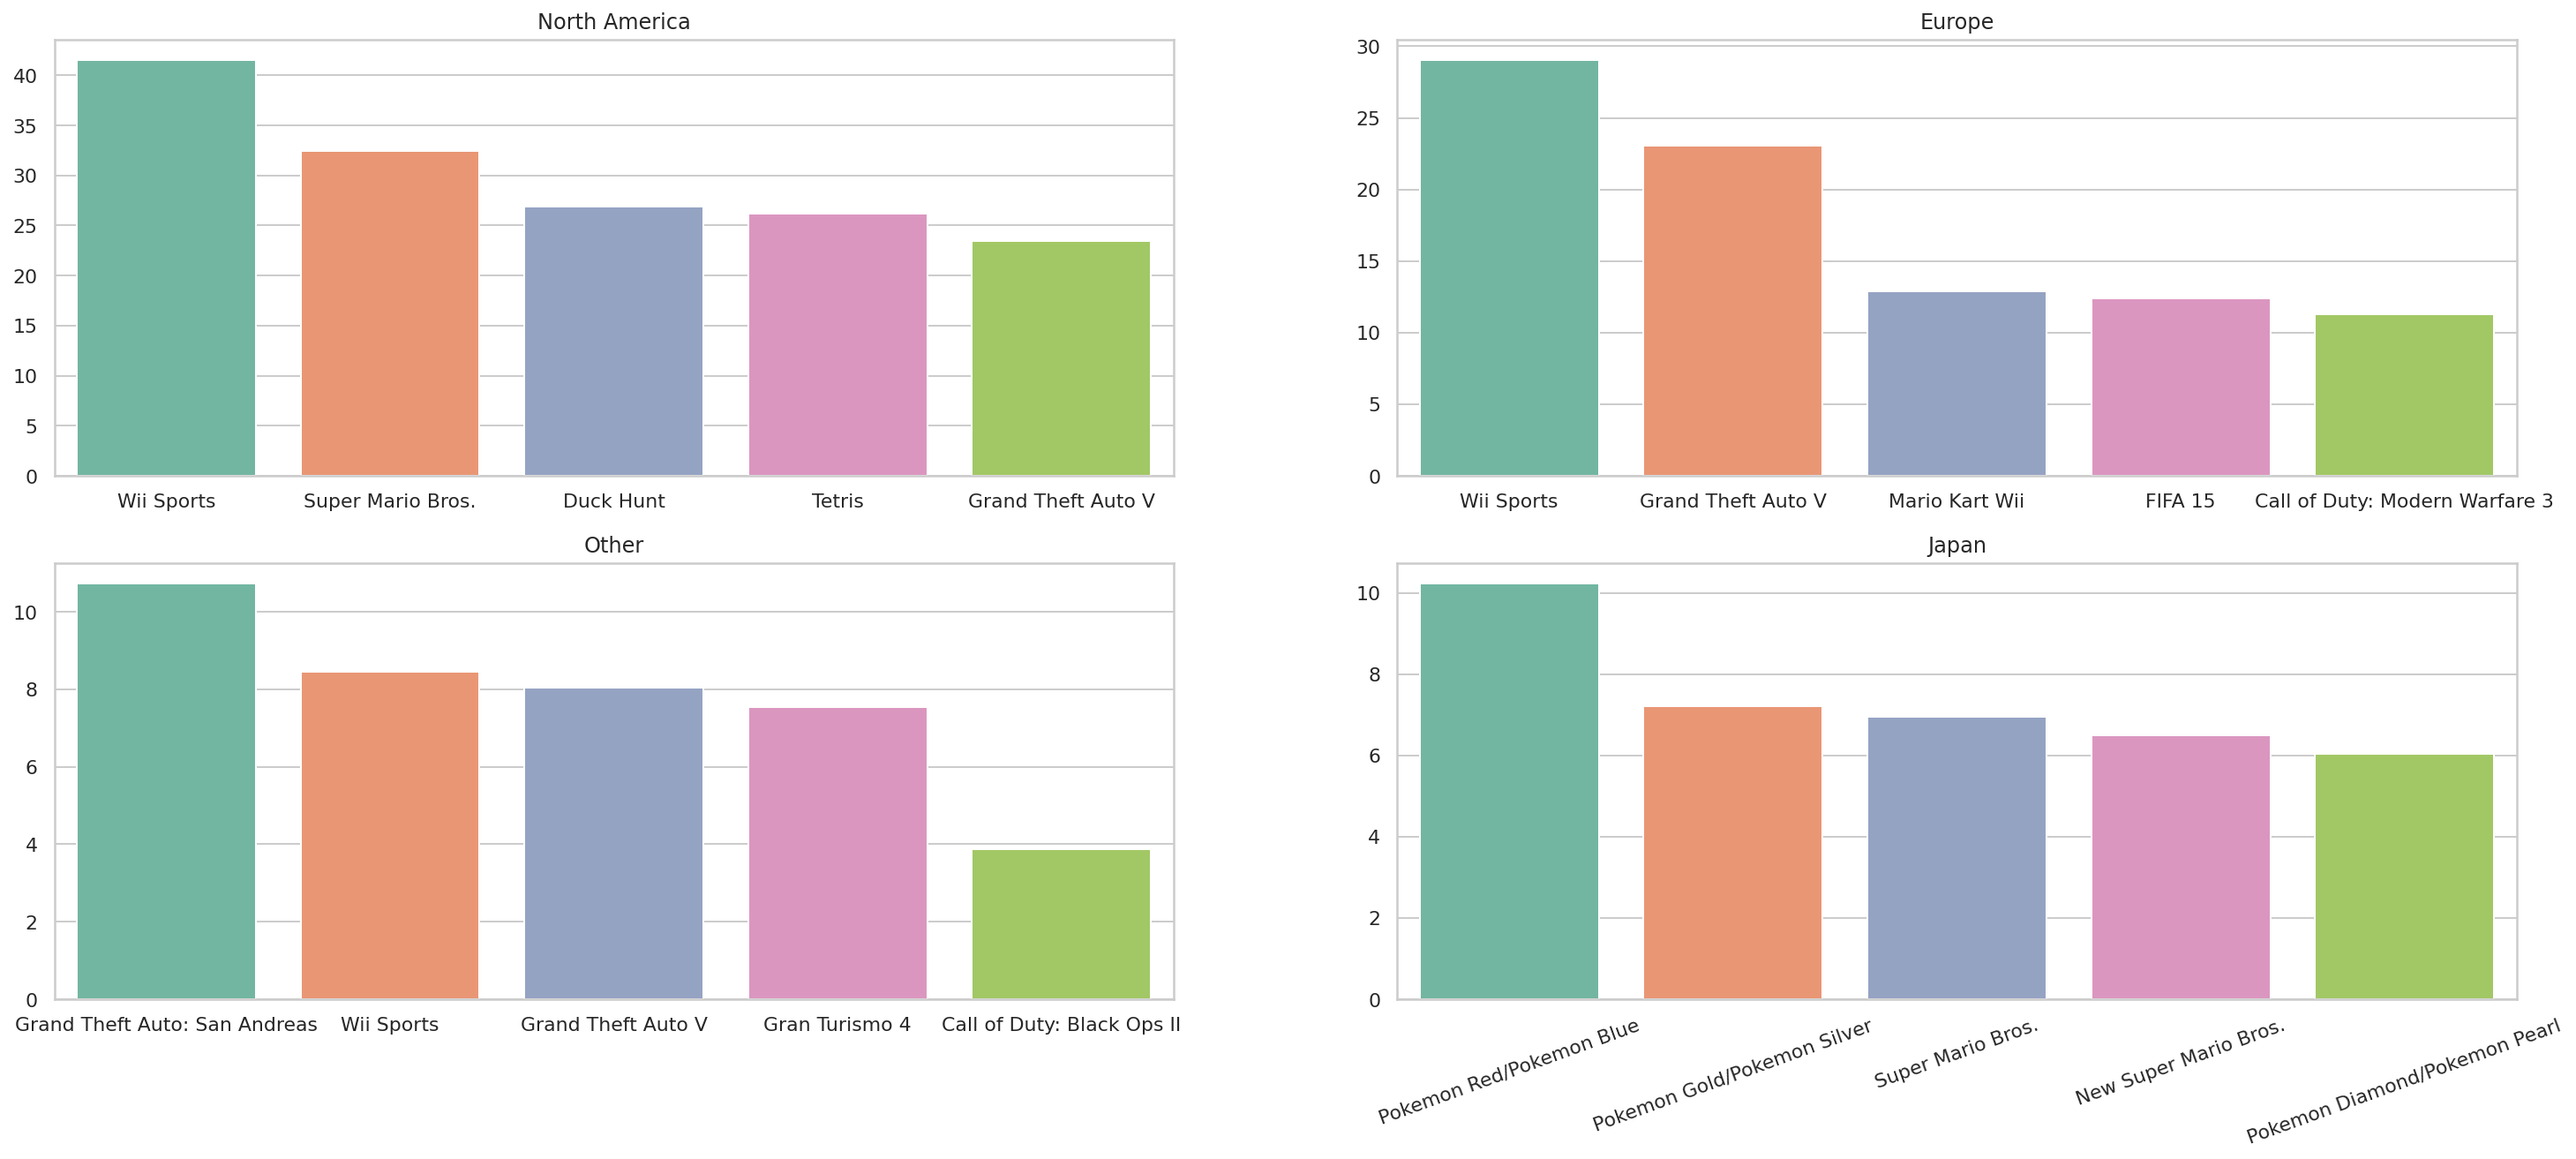

In [ ]:
# 그래프로 확인
fig, axes = plt.subplots(nrows=2,ncols=2)
sns.set_theme(style= 'whitegrid' )
fig.set_size_inches(25, 10)
sns.set_palette('Set2')
sns.barplot(data=NA, y='NA_Sales',x='Name',ax=axes[0][0])
sns.barplot(data=EU, y='EU_Sales',x='Name',ax=axes[0][1])
sns.barplot(data=JP, y='JP_Sales',x='Name',ax=axes[1][1])
sns.barplot(data=Other, y='Other_Sales',x='Name',ax=axes[1][0])
axes[0][0].set(xlabel='',ylabel='',title='North America')
axes[0][1].set(xlabel='', ylabel='',title='Europe')
axes[1][1].set(xlabel='', ylabel='',title='Japan')
axes[1][0].set(xlabel='', ylabel='',title='Other')
plt.xticks(rotation=20)
plt.show();

## Top5 Games overall (Sales)

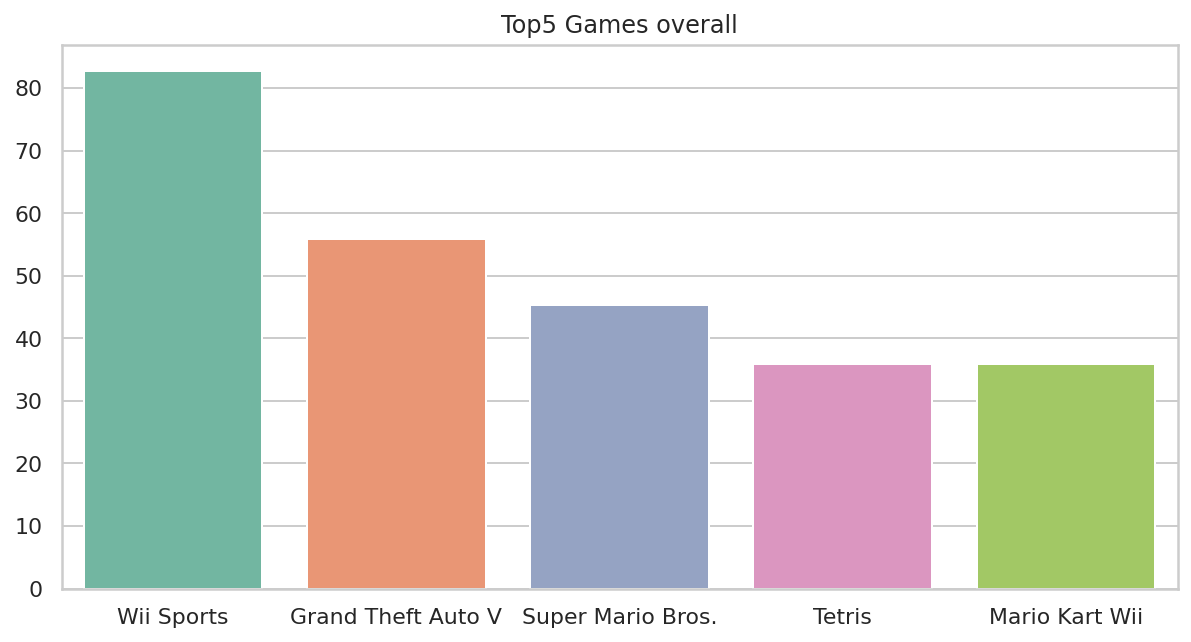

In [ ]:
# Top5 games in the world
Sum = df.pivot_table('Sum_Sales', columns='Name', aggfunc='sum').T
Sum = Sum.sort_values(by='Sum_Sales', ascending=False).iloc[0:5]
Sum.reset_index(inplace=True)

# 그래프로 확인 
plt.figure(figsize=(10,5))
sns.barplot(data=Sum, y='Sum_Sales',x='Name')
sns.set_palette('Set2',5)
plt.title('Top5 Games overall')
plt.xlabel('')
plt.ylabel('')
plt.show();


## Top5 Platform by Region

In [ ]:
# 지역별 Top 5 platform
NA_P = df.pivot_table('NA_Sales', columns='Platform', aggfunc='sum').T
NA_P = NA_P.sort_values(by='NA_Sales', ascending=False).iloc[0:5]
NA_P.reset_index(inplace=True)

EU_P = df.pivot_table('EU_Sales', columns='Platform', aggfunc='sum').T
EU_P = EU_P.sort_values(by='EU_Sales', ascending=False).iloc[0:5]
EU_P.reset_index(inplace=True)

JP_P = df.pivot_table('JP_Sales', columns='Platform', aggfunc='sum').T
JP_P = JP_P.sort_values(by='JP_Sales', ascending=False).iloc[0:5]
JP_P.reset_index(inplace=True)

Other_P = df.pivot_table('Other_Sales', columns='Platform', aggfunc='sum').T
Other_P = Other_P.sort_values(by='Other_Sales', ascending=False).iloc[0:5]
Other_P.reset_index(inplace=True)

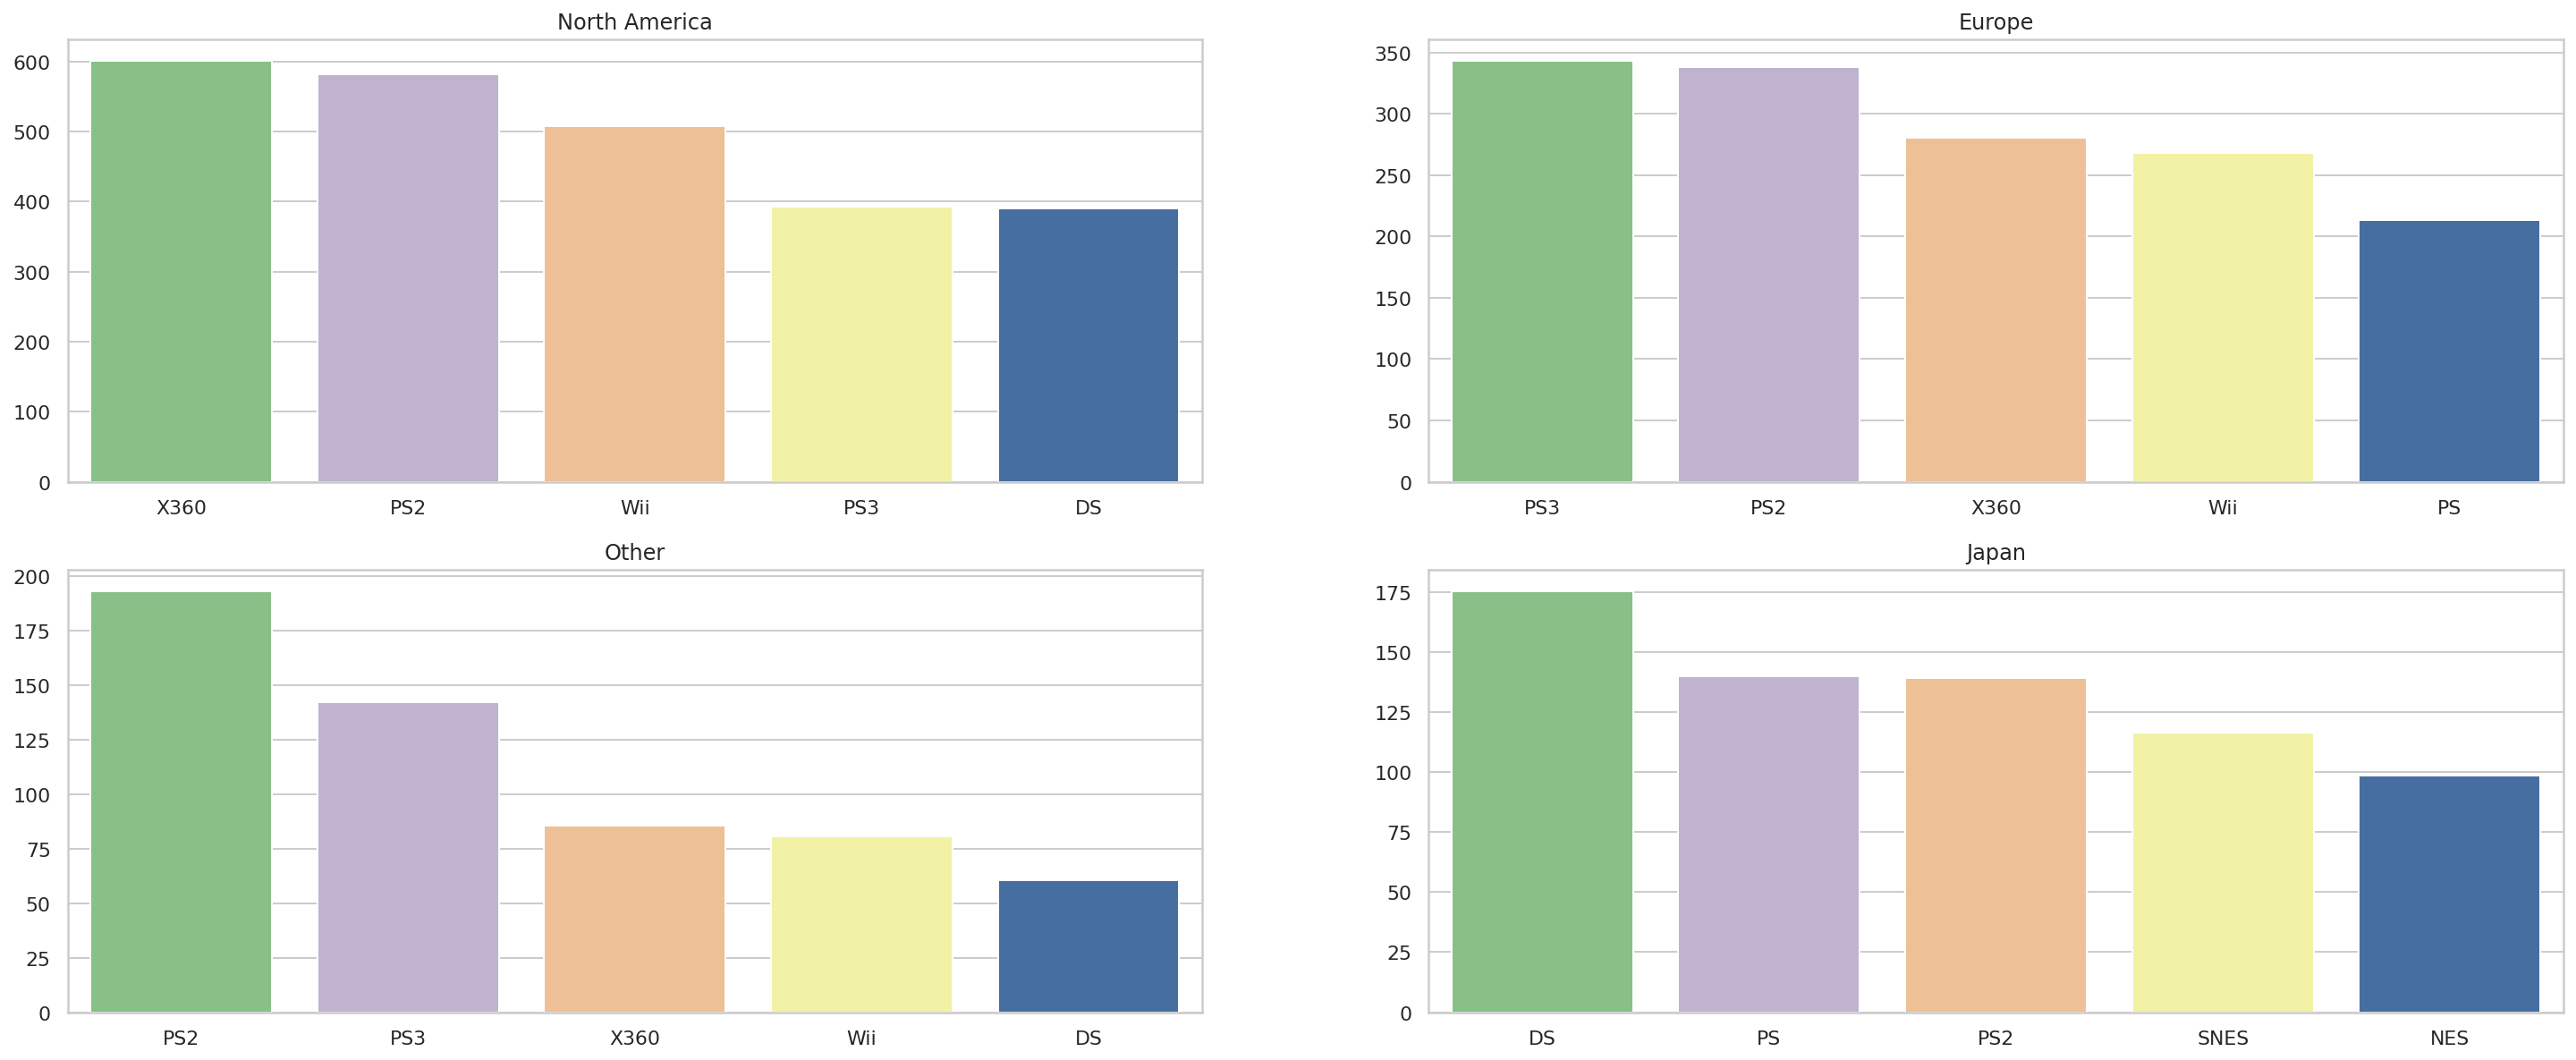

In [ ]:
# 그래프로 확인
fig, axes = plt.subplots(nrows=2,ncols=2)
sns.set_theme(style= 'whitegrid' )
fig.set_size_inches(25, 10)
sns.set_palette('Accent')
sns.barplot(data=NA_P, y='NA_Sales',x='Platform',ax=axes[0][0])
sns.barplot(data=EU_P, y='EU_Sales',x='Platform',ax=axes[0][1])
sns.barplot(data=JP_P, y='JP_Sales',x='Platform',ax=axes[1][1])
sns.barplot(data=Other_P, y='Other_Sales',x='Platform',ax=axes[1][0])
axes[0][0].set(xlabel='',ylabel='',title='North America')
axes[0][1].set(xlabel='', ylabel='',title='Europe')
axes[1][1].set(xlabel='', ylabel='',title='Japan')
axes[1][0].set(xlabel='', ylabel='',title='Other')
plt.show();

## Top5 Platform overall

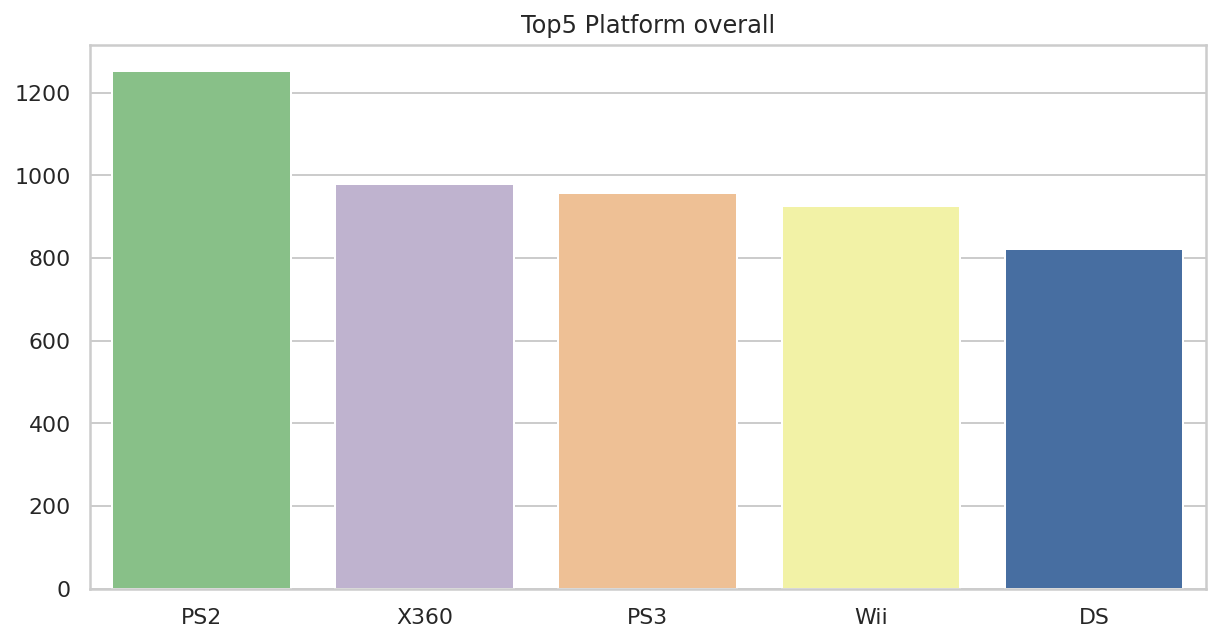

In [ ]:
# Top5 Platform overall
Sum_P = df.pivot_table('Sum_Sales', columns='Platform', aggfunc='sum').T
Sum_P = Sum_P.sort_values(by='Sum_Sales', ascending=False).iloc[0:5]
Sum_P.reset_index(inplace=True)

# 그래프로 확인 
plt.figure(figsize=(10,5))
sns.barplot(data=Sum_P, y='Sum_Sales',x='Platform')
sns.set_palette('Accent')
plt.title('Top5 Platform overall')
plt.xlabel('')
plt.ylabel('')
plt.show();

## Top7 Publishers (Release)

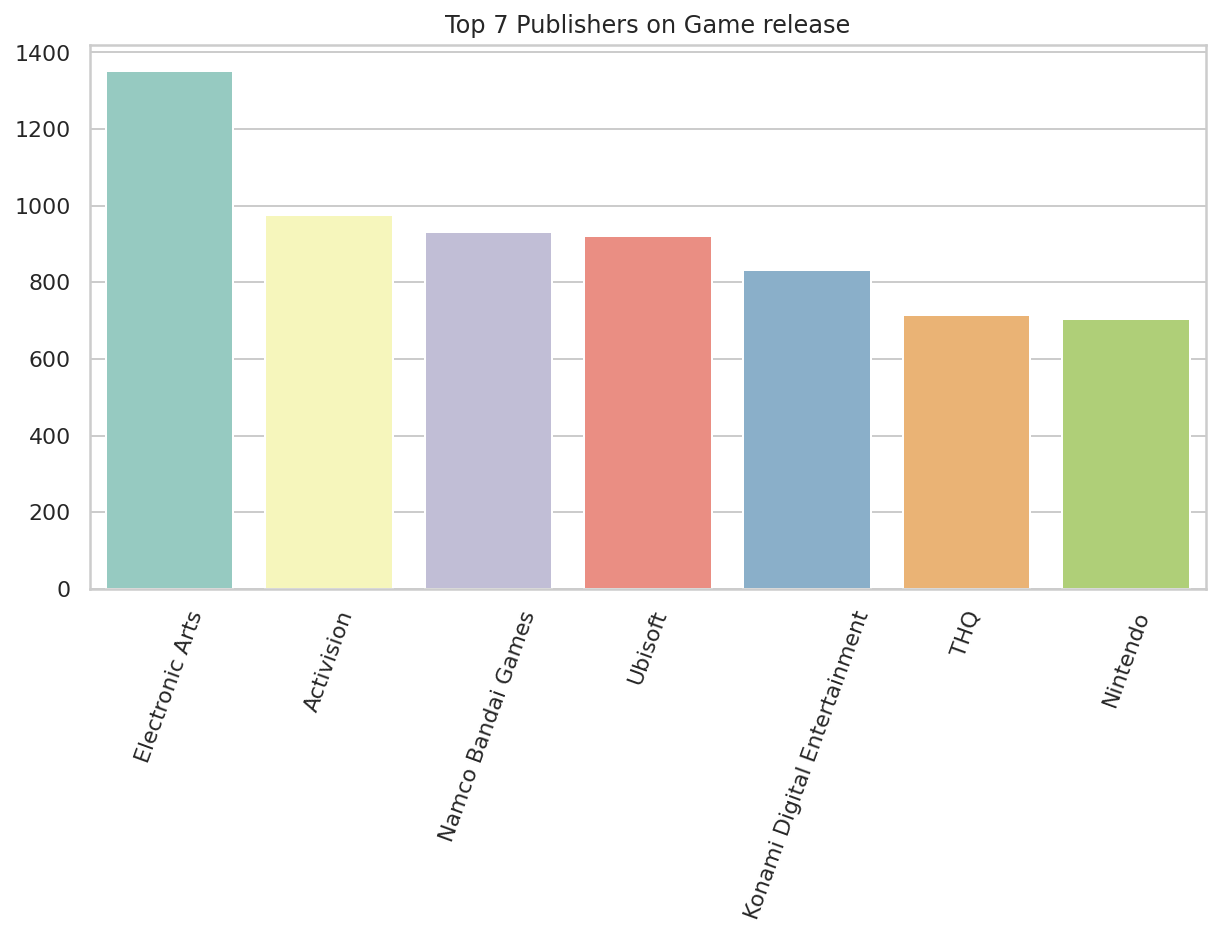

In [ ]:
# Publisher 별 game release 현황
pg_df = df.groupby('Publisher')['Name'].count().reset_index()
pg_df1 = pg_df.sort_values('Name',ascending=False).reset_index().iloc[0:7]
pg_df1.drop("index",axis = 1,inplace=True)

# 그래프로 확인
plt.figure(figsize=(10,5))
sns.barplot(data=pg_df1, y='Name',x='Publisher')
sns.set_palette('Set3',7)
plt.xticks(rotation=70)
plt.title('Top 7 Publishers on Game release')
plt.xlabel('')
plt.ylabel('')
plt.show();

## Top7 publishers (Sales)

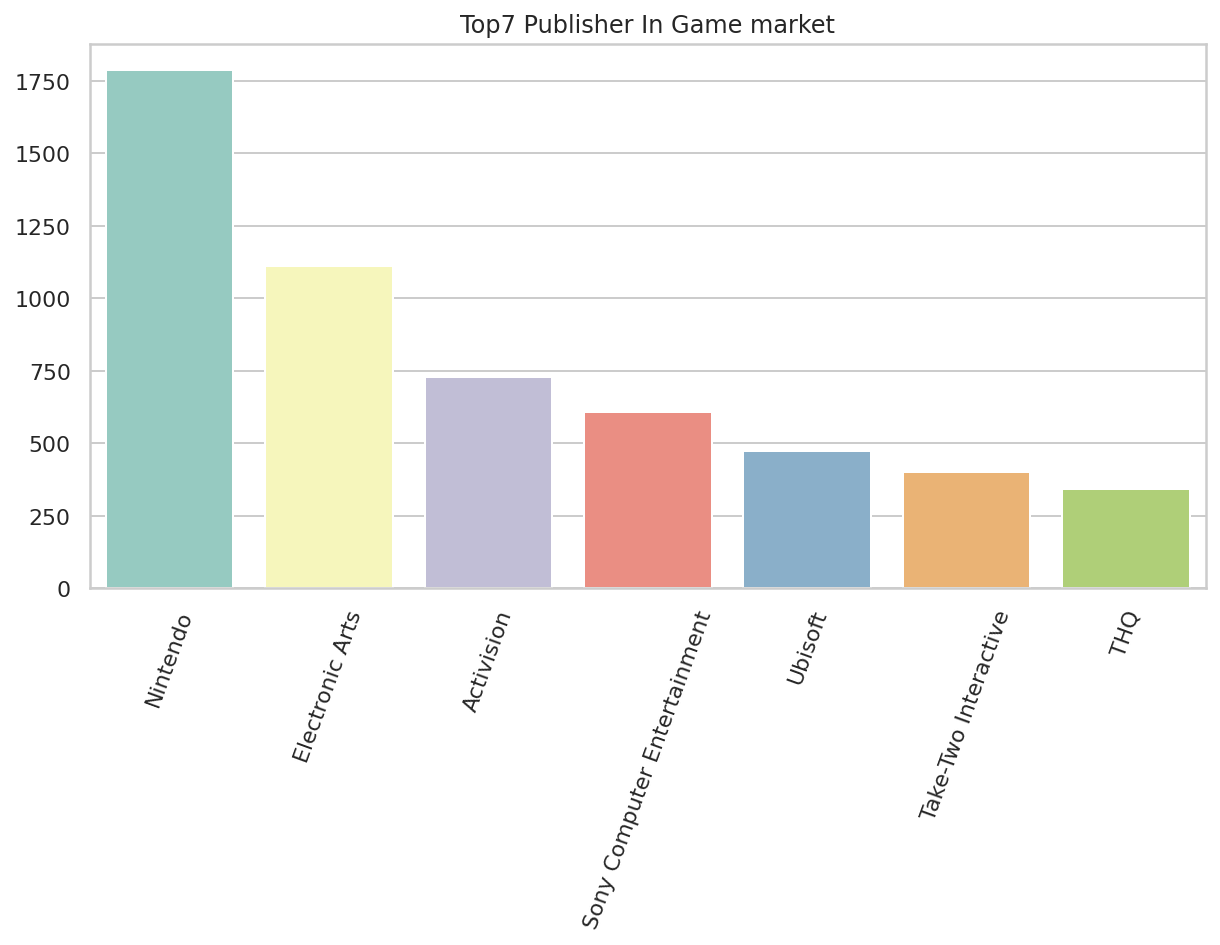

In [ ]:
# Top 7 Publisher의 매출 현황
Ps_df = pd.DataFrame(df.groupby('Publisher')['Sum_Sales'].sum())
Ps_df1 = Ps_df.sort_values(by=['Sum_Sales'], ascending=False).iloc[0:7]
Ps_df1.reset_index(inplace=True)

# 그래프로 확인
plt.figure(figsize=(10,5))
sns.barplot(data=Ps_df1, y='Sum_Sales',x='Publisher')
sns.set_palette('Paired_r')
plt.xticks(rotation=70)
plt.title('Top7 Publisher In Game market')
plt.xlabel('')
plt.ylabel('')
plt.show();